In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize, stats
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import pycbc.conversions as conv

from gwbench import injections
from gwbench import network
from gwbench import snr

In [68]:
plotdir = 'power_law_hyper_param_plots/'

alpha_inj = -3.5

import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)

# Read simulation

In [69]:
# File with Mc biases

# files = [f'powerlaw_3.5_lams/powerlaw_alpha_3.5_lam_0_1_Mc_0_1296.csv']
# files = ['fpowerlaw_1.0_lams/powerlaw_alpha_1.0_lam_0_1_Mc_0_test.csv']
files = [f'powerlaw_{np.abs(alpha_inj):.1f}_lams/powerlaw_alpha_{np.abs(alpha_inj):.1f}_lam_0_1_Mc_0_test.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc_raw = df1.loc[~(df1==0).all(axis=1)]
df_mc_raw = df_mc_raw[df_mc_raw["Mc"] > 0]
# df_mc_raw = df_mc_raw[df_mc_raw["m1"] < 20]
# df_mc_raw = df_mc_raw[df_mc_raw["z"] < 2]
print("Total number of events:",len(df_mc_raw))


Total number of events: 1296


In [70]:
# File with eta biases

# files = [f'powerlaw_3.5_lams/powerlaw_alpha_3.5_lam_0_1_eta_0_1296.csv']
# files = [f'powerlaw_1.0_lams/powerlaw_alpha_1.0_lam_0_1_eta_0_test.csv']
files = [f'powerlaw_{np.abs(alpha_inj):.1f}_lams/powerlaw_alpha_{np.abs(alpha_inj):.1f}_lam_0_1_eta_0_test.csv']

df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta_raw = df1.loc[~(df1==0).all(axis=1)]
df_eta_raw = df_eta_raw[df_eta_raw["Mc"] > 0]
# df_eta_raw = df_eta_raw[df_eta_raw["m1"] < 20]
# df_eta_raw = df_eta_raw[df_eta_raw["z"] < 2]
print("Total number of events:",len(df_eta_raw))

Total number of events: 1296


## Sample from the events if needed

In [71]:
# # Select random subset of the data
# n_samples = 1200
# sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
# df_mc = df_mc_raw.iloc[sample_indices]
# df_eta = df_eta_raw.iloc[sample_indices]

# select all data
df_mc = df_mc_raw
df_eta = df_eta_raw

$$ p(\alpha) = e^{-N_s} \Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) $$

The products are over all events. 

Or, in log likelihood space, 
$$ log(p(\alpha)) = log(e^{-N_s}) + log(\Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) )$$

which simplifies to 

$$ log(p(\alpha)) = -N_s + \Sigma_{i=1}^{N_t} log(N_s * \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1)) $$

#  Define the functions

In [72]:
def p_m1(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


def normal_dist(m1, mu, sigma):
    A = np.sqrt(2*np.pi) * sigma
    return np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A

def trunc_normal_dist(m1, mu, sigma, m_min=None, m_max=None):
    if m_min is None:
        m_min = np.min(m1)
    if m_max is None:
        m_max = np.max(m1)
        
    a, b = (m_min - mu) / sigma, (m_max - mu) / sigma
    return stats.truncnorm.pdf(m1, a, b, loc = mu, scale = sigma)

def sigmoid(x, a):
    return 1/(1 + np.exp(a-x))

In [73]:
m1_min=5
m1_max=100
alpha=-3.5


m1 = np.linspace(m1_min, m1_max, 300000)
print(integrate.trapezoid(p_m1(m1, alpha, m1_min, m1_max), m1))

1.0000000007123995


In [74]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 34
sigma = 1.4
print(integrate.trapezoid(normal_dist(m1, mu, sigma), m1))

1.0


In [75]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 134
sigma = 1.4
print(integrate.trapezoid(trunc_normal_dist(m1, mu, sigma), m1))

1.0000025188661694


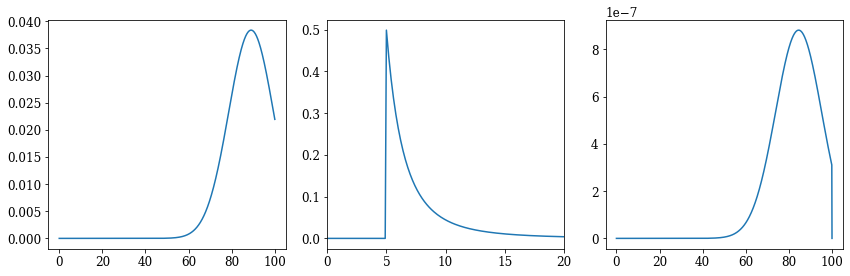

In [76]:
# Visualize the defined functions for sanity

m1_min=5
m1_max=100

m1 = np.linspace(0, m1_max, 1000)
mu = 89
sigma = 10.4
alpha=-3.5

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax1.plot(m1, normal_dist(m1, mu, sigma))
ax2.plot(m1, p_m1(m1, alpha, m1_min, m1_max))
ax2.set_xlim(0, 20)
ax3.plot(m1, (normal_dist(m1, mu, sigma)*p_m1(m1, alpha, m1_min, m1_max)))


plt.tight_layout()
plt.show()


# Compute Hyper posterior

In [77]:
def log_likelihood_alpha(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=30, \
        m1_min_int = 5., m1_max_int=500., n_m1_int=10000, \
        m1_min_pow = 5., m1_max_pow=500., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)
    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    log_p_alpha = np.zeros(n_alpha)

    for a in range(n_alpha):
        alpha = alpha_range[a]
        total_int = 0

        for i in range(Nt):
            integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * trunc_normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i], m1_min_int, m1_max_int)
            int_term = integrate.trapezoid(integrand, m1_int_range)
            # if int_term == 0:
            #     int_term=1.0

            total_int = total_int + np.log(Ns) + np.log(int_term)
            
        log_p_alpha[a] = -Ns + total_int
        
    return log_p_alpha, alpha_range

## $\lambda$=0, Source Frame masses

In [78]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
z = df_mc["z"]
mchirp = df_mc["Mc"]/ (1+z)
eta = df_mc["eta"]

sigMc_raw = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]
sigZ = df_mc["z_stat_err"]

sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


m1_mu_detections = df_mc["m1"] / (1+z)

aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
m1_sigma_events = m1_sigma_events.values

# sample mu from the detection gaussians to avoid Biases
m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

In [79]:
print(np.sum(m1_mu_sampled<5))
print(np.sum(m1_mu_sampled>100))

103
0


In [80]:
log_p_alpha_lam_0_src, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_inj-0.5, alpha_max=alpha_inj+0.5, n_alpha=100, \
    m1_min_int = 5., m1_max_int=500., n_m1_int=20000,\
    m1_min_pow = 5., m1_max_pow=100.,\
    Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"]))
log_alpha_norm =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)

most likely alpha (IN SOURCE FRAME) = -3.686868686868687


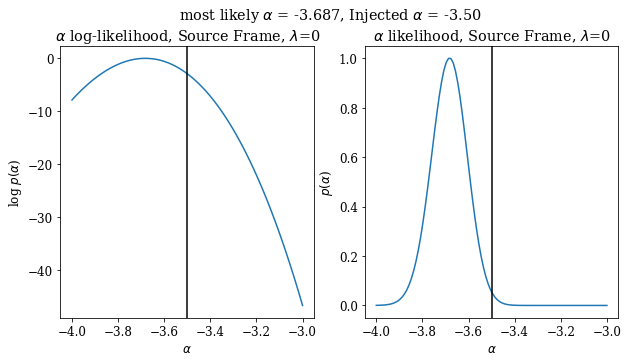

In [81]:
print("most likely alpha (IN SOURCE FRAME) =",alpha_range_src[np.argmax(log_p_alpha_lam_0_src)])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_src, log_alpha_norm)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("$\\alpha$ log-likelihood, Source Frame, $\lambda$=0")

axes[1].plot(alpha_range_src, np.exp(log_alpha_norm))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("$\\alpha$ likelihood, Source Frame, $\lambda$=0")

plt.suptitle(f"most likely $\\alpha$ = {alpha_range_src[np.argmax(log_p_alpha_lam_0_src)]:.3f}, Injected $\\alpha$ = {alpha_inj:.2f}", y=0.99)

plt.savefig(plotdir+f'alpha_{alpha_inj:.1f}_hyper_posterior.pdf')
plt.show()

Try with fewer events:

In [64]:
log_p_alpha_lam_0_src_100, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
    alpha_min=-4.4, alpha_max=-2.7, n_alpha=30, \
    m1_min_pow = 5, m1_max_pow=100., \
    m1_min_int = 5, m1_max_int=200., n_m1_int=10000, Ns=100, Nt=100)
log_p_alpha_lam_0_src_100 =log_p_alpha_lam_0_src_100 - np.max(log_p_alpha_lam_0_src_100)

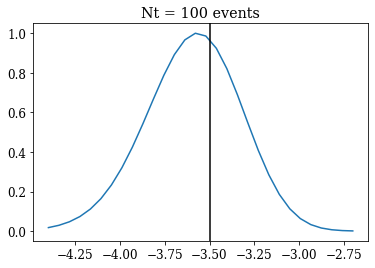

In [65]:
plt.plot(alpha_range_src, np.exp(log_p_alpha_lam_0_src_100))
plt.axvline(x=-3.5, color='k')
plt.title("Nt = 100 events")
plt.show()

## Scipy curve_fit test

In [83]:
mask = (m1_mu_detections<2000)

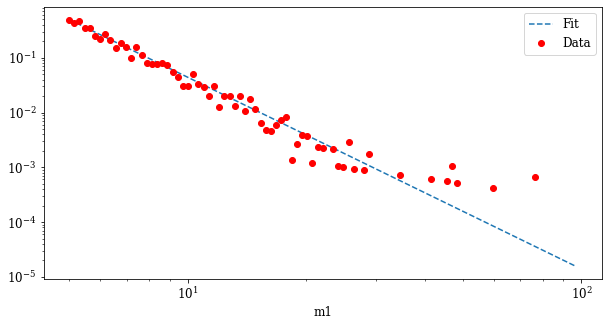

[-3.50185660e+00  5.00000000e+00  7.67578725e+03]


In [84]:
target_func = p_m1
bins = np.geomspace(5, 100, 100)

y, X = np.histogram(m1_mu_detections[mask], bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()

popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-2.3, 5, 100])

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label='Fit')
# plt.plot(X, p_m1(X,  -3.696, 5, 100), '--', label='Fit')

plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.loglog()
plt.legend()

# plt.xlim(5, 30)

plt.show()


print(popt)

## Detector Frame

All the masses here are in the Detector Frame! The original power law sampling was done in SOURCE FRAME.

In [196]:
# m1_mu_events = df_mc["m1"] # Add bias here if necessary

# mchirp = df_mc["Mc"]
# eta = df_mc["eta"]
# sigMc = df_mc["Mc_stat_err"]
# sigEta = df_eta["eta_stat_err"]

# aux0=((3.+((3.*((1.+(-4.*eta))**0.5))+(10.*(((1.+(-4.*eta))**-0.5)*eta))))**2)
# aux1=(aux0*((mchirp**2)*(sigEta**2)))+(25.*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*(sigMc**2))))
# m1_sigma_events=0.1*(np.sqrt(((eta**-3.2)*aux1)))



In [217]:
# m1_min = 5.0
# m1_max = 500.0
# Ns = np.sum(df_mc["snr"]>8)
# Nt = len(df_mc["Mc"])

# m1_int_range = np.linspace(m1_min, m1_max, 10000)
# dm = (m1_int_range[1]-m1_int_range[0])

# n_alpha = 30
# alpha_range_det = np.linspace(-1.5, -1.3, n_alpha)
# dalpha = alpha_range_det[1] - alpha_range_det[0]
# log_p_alpha_lam_0_det = np.zeros(n_alpha)

# for a in range(n_alpha):
#     alpha = alpha_range_det[a]
#     total_int = 0

#     for i in range(100):
#         integrand = dm * p_m1(m1_int_range, alpha, m1_min, m1_max) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
#         int_term = np.sum(integrand)

#         total_int = total_int + np.log(Ns) + np.log(int_term)
        
#     log_p_alpha_lam_0_det[a] = -Ns + total_int



In [218]:
# print("most likely alpha (IN DETECTOR FRAME) =",alpha_range_det[np.argmin(log_p_alpha_lam_0_det)])

# plt.plot(alpha_range_det, log_p_alpha_lam_0_det)
# plt.ylabel("log $p(\\alpha$)")
# plt.xlabel("$\\alpha$")
# plt.title("$\\alpha$ likelihood, Detector Frame, $\lambda$=0")

# # plt.savefig(plotdir+'alpha_log_likelihood_lam_0_det.pdf')
# plt.show()


In [219]:
# np.min(log_p_alpha_lam_0_det)

In [220]:
# log_alpha=log_p_alpha_lam_0_det - np.max(log_p_alpha_lam_0_det)
# np.exp(log_alpha)

## Detector Frame masses

# Compute Hyper posterior ($\lambda = 1$)

## Detector Frame masses

I'm getting some weird results for when the bias makes eta exceed 0.25.

In [123]:
# Add bias here if necessary
mchirp = df_mc["Mc"]+df_mc["bias_19"]
eta = np.minimum(df_eta["eta"]+df_eta["bias_19"], 0.25)

m1_mu_events = conv.mass1_from_mchirp_eta(mchirp, eta)

# Use unbiased mc, eta for sigma_m1 calc, otherwise I get a bunch of infs
mchirp = df_mc["Mc"]
eta = df_mc["eta"]
sigMc = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]

aux0=((3.+((3.*((1.+(-4.*eta))**0.5))+(10.*(((1.+(-4.*eta))**-0.5)*eta))))**2)
aux1=(aux0*((mchirp**2)*(sigEta**2)))+(25.*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*(sigMc**2))))
m1_sigma_events=0.1*(np.sqrt(((eta**-3.2)*aux1)))



In [124]:
m1_min = 5.0
m1_max = 500.0
Ns = np.sum(df_mc["snr"]>8)
Nt = len(df_mc["Mc"])

m1_int_range = np.linspace(m1_min, m1_max, 20000)

n_alpha = 30
alpha_range_det = np.linspace(-2, -1, n_alpha)
log_p_alpha_lam_1_det = np.zeros(n_alpha)

for a in range(n_alpha):
    alpha = alpha_range_det[a]
    total_int = 0

    for i in range(Nt):
        integrand = p_m1(m1_int_range, alpha, m1_min, m1_max) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
        int_term = np.sum(integrand)

        total_int = total_int + np.log(Ns) + np.log(int_term)
        
    log_p_alpha_lam_1_det[a] = -Ns * total_int
    

most likely alpha (IN DETECTOR FRAME) = -1.4482758620689655


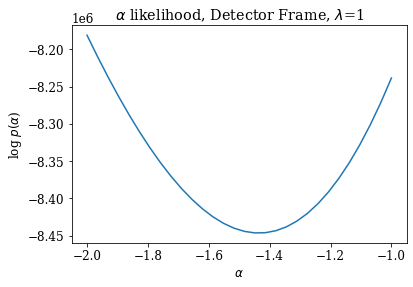

In [125]:
print("most likely alpha (IN DETECTOR FRAME) =",alpha_range_det[np.argmin(log_p_alpha_lam_1_det)])

plt.plot(alpha_range_det, log_p_alpha_lam_1_det)
plt.ylabel("log $p(\\alpha$)")
plt.xlabel("$\\alpha$")
plt.title("$\\alpha$ likelihood, Detector Frame, $\lambda$=1")
# plt.savefig(plotdir+'alpha_log_likelihood_lam_1_det.pdf')

plt.show()

## Source Frame masses

In [126]:
# Add bias here if necessary
mchirp = (df_mc["Mc"]  / (1+df_mc["z"]) ) + df_mc["bias_19"] 
eta = np.minimum(df_eta["eta"]+df_eta["bias_19"], 0.25)

m1_mu_events = conv.mass1_from_mchirp_eta(mchirp, eta)

# Use unbiased mc, eta for sigma_m1 calc, otherwise I get a bunch of infs
mchirp = df_mc["Mc"]  / (1+df_mc["z"])
eta = df_mc["eta"]
sigMc = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]

aux0=((3.+((3.*((1.+(-4.*eta))**0.5))+(10.*(((1.+(-4.*eta))**-0.5)*eta))))**2)
aux1=(aux0*((mchirp**2)*(sigEta**2)))+(25.*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*(sigMc**2))))
m1_sigma_events=0.1*(np.sqrt(((eta**-3.2)*aux1)))


m1_min = 5.0
m1_max = 500.0
Ns = np.sum(df_mc["snr"]>8)
Nt = len(df_mc["Mc"])

m1_int_range = np.linspace(m1_min, m1_max, 10000)

n_alpha = 30
alpha_range_src = np.linspace(-6, -2, n_alpha)
log_p_alpha_lam_1_src = np.zeros(n_alpha)

for a in range(n_alpha):
    alpha = alpha_range_src[a]
    total_int = 0

    for i in range(Nt):
        integrand = p_m1(m1_int_range, alpha, m1_min, m1_max) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
        int_term = np.sum(integrand)

        total_int = total_int + np.log(Ns) + np.log(int_term)
        
    log_p_alpha_lam_1_src[a] = -Ns * total_int

most likely alpha (IN SOURCE FRAME) = -4.068965517241379


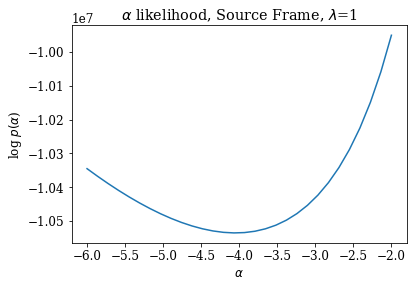

In [127]:
print("most likely alpha (IN SOURCE FRAME) =",alpha_range_src[np.argmin(log_p_alpha_lam_1_src)])

plt.plot(alpha_range_src, log_p_alpha_lam_1_src)
plt.ylabel("log $p(\\alpha$)")
plt.xlabel("$\\alpha$")
plt.title("$\\alpha$ likelihood, Source Frame, $\lambda$=1")
# plt.savefig(plotdir+'alpha_log_likelihood_lam_1_src.pdf')

plt.show()

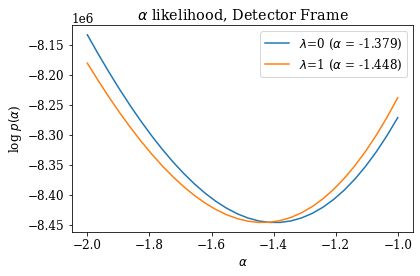

In [131]:
alpha_min_lam_0_det = alpha_range_det[np.argmin(log_p_alpha_lam_0_det)]
alpha_min_lam_1_det = alpha_range_det[np.argmin(log_p_alpha_lam_1_det)]

diff = np.min(log_p_alpha_lam_0_det) - np.min(log_p_alpha_lam_1_det)

plt.plot(alpha_range_det, log_p_alpha_lam_0_det - diff, label=f'$\lambda$=0 ($\\alpha$ = {alpha_min_lam_0_det:.3f})')
plt.plot(alpha_range_det, log_p_alpha_lam_1_det, label=f'$\lambda$=1 ($\\alpha$ = {alpha_min_lam_1_det:.3f})')
plt.ylabel("log $p(\\alpha$)")
plt.xlabel("$\\alpha$")
plt.title("$\\alpha$ likelihood, Detector Frame")
plt.legend()
plt.tight_layout()
plt.savefig(plotdir+'alpha_log_likelihood_det.pdf')
plt.show()

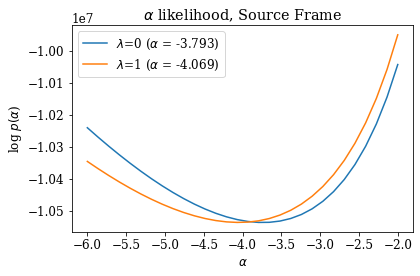

In [130]:
alpha_min_lam_0_src = alpha_range_src[np.argmin(log_p_alpha_lam_0_src)]
alpha_min_lam_1_src = alpha_range_src[np.argmin(log_p_alpha_lam_1_src)]

diff = np.min(log_p_alpha_lam_0_src) - np.min(log_p_alpha_lam_1_src)

plt.plot(alpha_range_src, log_p_alpha_lam_0_src - diff, label=f'$\lambda$=0 ($\\alpha$ = {alpha_min_lam_0_src:.3f})')
plt.plot(alpha_range_src, log_p_alpha_lam_1_src, label=f'$\lambda$=1 ($\\alpha$ = {alpha_min_lam_1_src:.3f})')
plt.ylabel("log $p(\\alpha$)")
plt.xlabel("$\\alpha$")
plt.title("$\\alpha$ likelihood, Source Frame")
plt.legend()
plt.tight_layout()
plt.savefig(plotdir+'alpha_log_likelihood_src.pdf')
plt.show()